In [ ]:
!pip install nilearn
!pip install nibabel
!pip install gif_your_nifti
!pip install tensorflow
!pip install kaggle
!pip install dipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 89.9 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement gif_your_nifti (from versions: none)
ERROR: No matching distribution found for gif_your_nifti
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 106.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 4.4 MB/s eta 0:00:00


In [ ]:
#%%
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps

# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt

# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *


from PIL import Image
from collections import Counter

import torch
import torch.nn.functional as F
import torchvision.transforms as transforms

Download data from kaggle

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!mv kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!kaggle config set -n apikey -v ~/.kaggle/kaggle.json
!kaggle datasets download -d awsaf49/brats20-dataset-training-validation

- apikey is now set to: /root/.kaggle/kaggle.json
Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation
License(s): CC0-1.0


In [ ]:
import zipfile
path_to_zip_file = "brats20-dataset-training-validation.zip"
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall("brats20-dataset-training-validation")

In [ ]:
#setup
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

# DEFINE seg-areas
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE',  # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING'  # original 4 -> converted into 3 later
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5
VOLUME_SLICES = 100
VOLUME_START_AT = 22  # first slice of volume that we will include

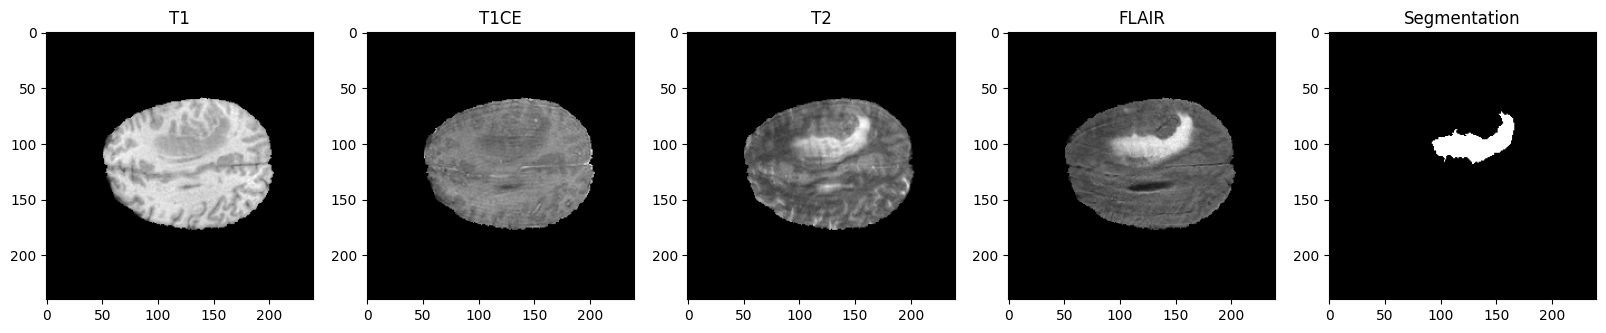

In [ ]:
##plotting
train_path ='brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_'
t1_img=nib.load(train_path + 't1.nii')
t1ce_img=nib.load(train_path + 't1ce.nii')
t2_img=nib.load(train_path + 't2.nii')
flair_img=nib.load(train_path + 'flair.nii')
seg_img=nib.load(train_path + 'seg.nii')

# Get the image data
t1_data = t1_img.get_fdata()
t1ce_data = t1ce_img.get_fdata()
t2_data = t2_img.get_fdata()
flair_data = flair_img.get_fdata()
seg_data = seg_img.get_fdata()

# Plot the 100th slice of the 4 RMI modalities and the segmentation
slice_nb = 100

fig, axs = plt.subplots(1, 5, figsize=(20,20))
axs[0].imshow(t1_data[:,:,slice_nb], cmap="gray")
axs[0].set_title('T1')
axs[1].imshow(t1ce_data[:,:,slice_nb], cmap="gray")
axs[1].set_title('T1CE')
axs[2].imshow(t2_data[:,:,slice_nb], cmap="gray")
axs[2].set_title('T2')
axs[3].imshow(flair_data[:,:,slice_nb], cmap="gray")
axs[3].set_title('FLAIR')
axs[4].imshow(seg_data[:,:,slice_nb], cmap="gray")
axs[4].set_title('Segmentation')
plt.show()

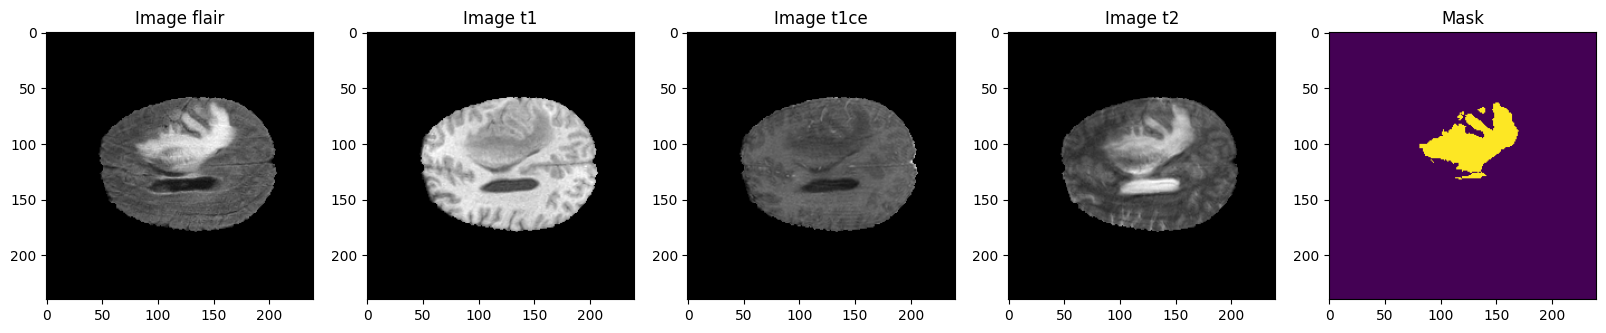

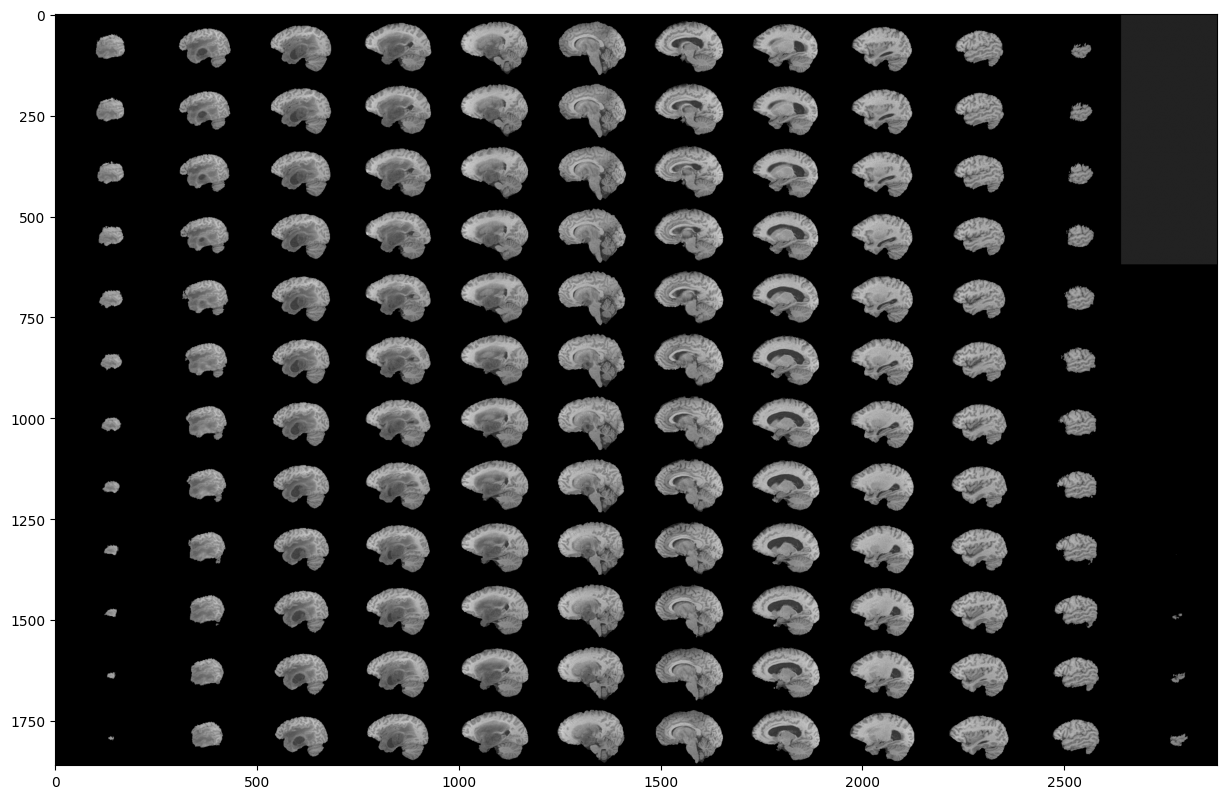

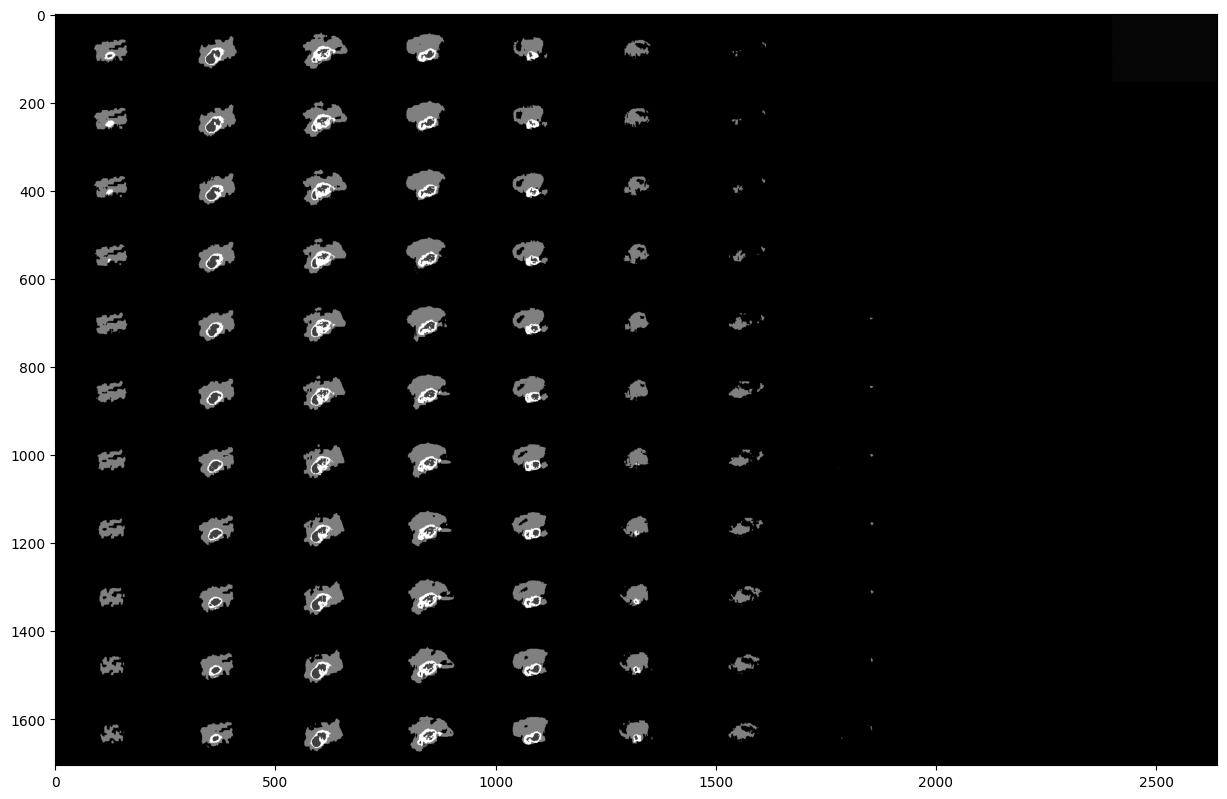

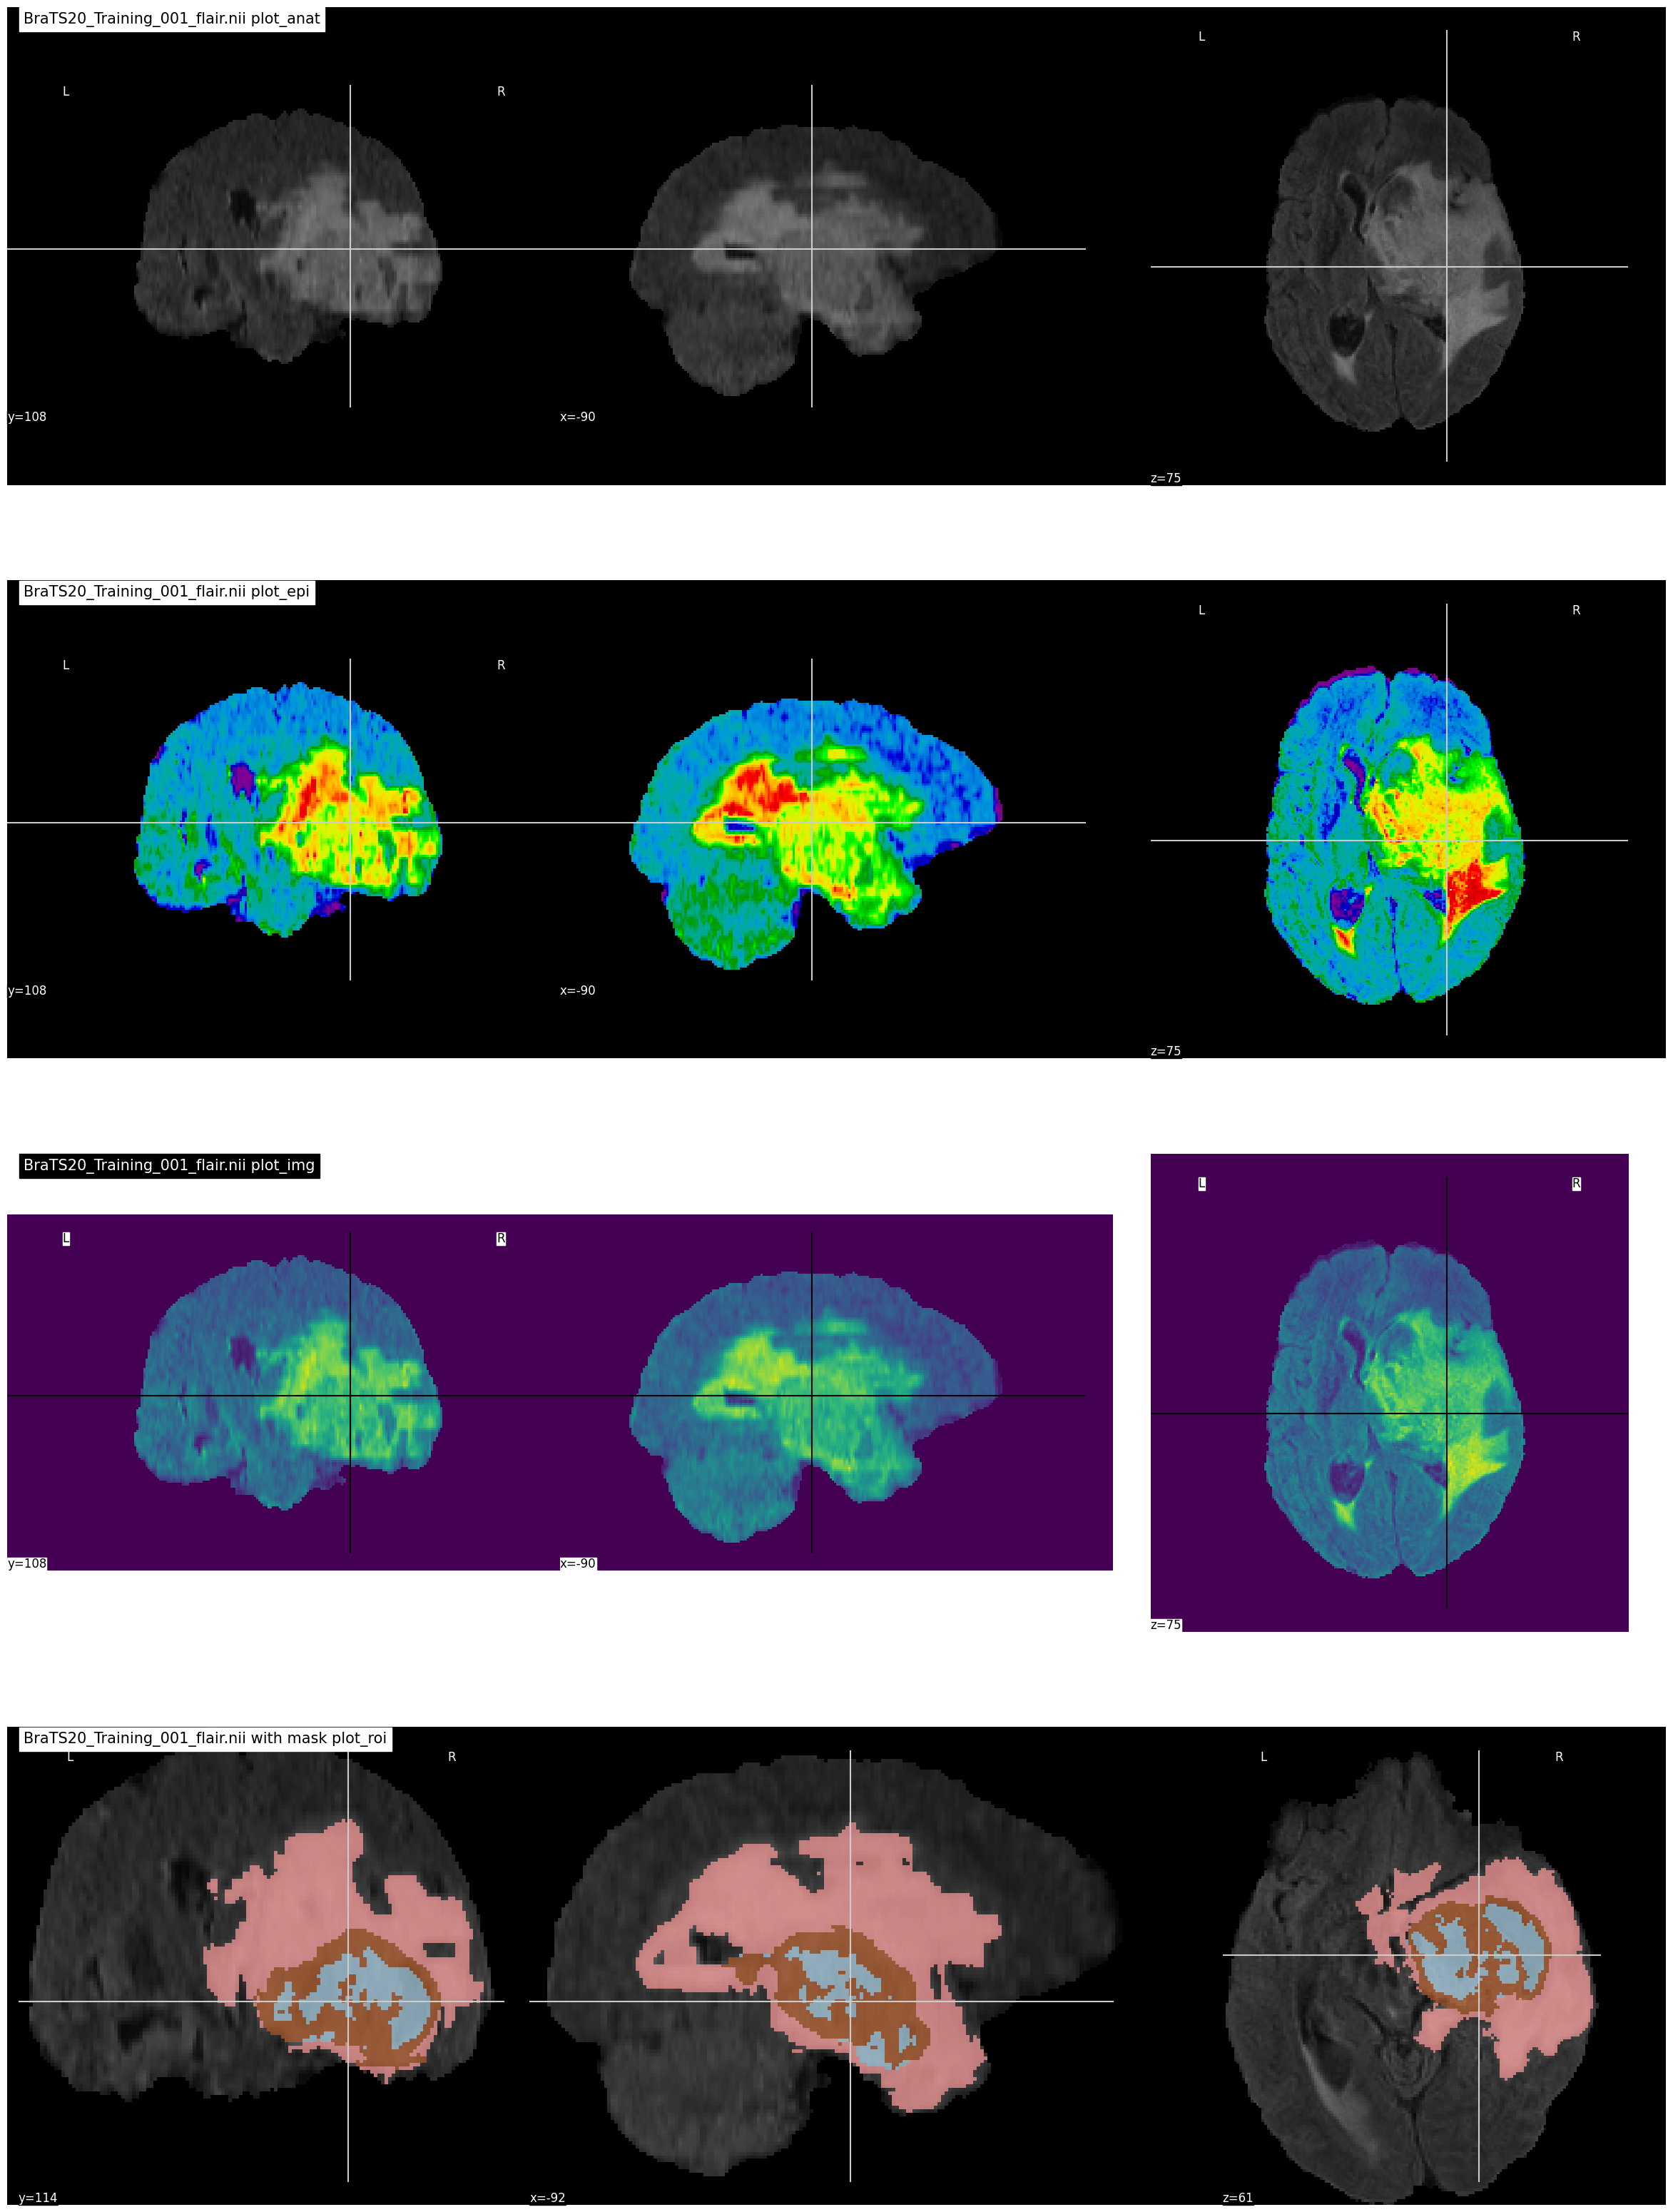

In [ ]:


TRAIN_DATASET_PATH = 'brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = 'brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

# Load test images
test_image_flair = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
test_image_t1 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
test_image_t1ce = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t2 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
test_mask = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()

# Plot test images
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 10))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap='gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap='gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap='gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap='gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')

# Show whole nifti data
fig, ax1 = plt.subplots(1, 1, figsize=(15,15))
ax1.imshow(rotate(montage(test_image_t1[50:-50,:,:]), 90, resize=True), cmap='gray')

# Show segment of tumor
fig, ax1 = plt.subplots(1, 1, figsize=(15,15))
ax1.imshow(rotate(montage(test_mask[60:-60,:,:]), 90, resize=True), cmap='gray')



# Show segments of tumor using different effects
niimg = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii')
nimask = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii')

fig, axes = plt.subplots(nrows=4, figsize=(30, 40))

nlplt.plot_anat(niimg,
               title='BraTS20_Training_001_flair.nii plot_anat',
               axes=axes[0])

nlplt.plot_epi(niimg,
              title='BraTS20_Training_001_flair.nii plot_epi',
              axes=axes[1])

nlplt.plot_img(niimg,
              title='BraTS20_Training_001_flair.nii plot_img',
              axes=axes[2])

nlplt.plot_roi(nimask,
              title='BraTS20_Training_001_flair.nii with mask plot_roi',
              bg_img=niimg,
              axes=axes[3], cmap='Paired')

plt.show()



In [ ]:
#example slice for processing
raw_slice = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()

#NLM denoising

In [ ]:
#NLM denoising on a single slice
raw_slice = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
denoised_NLM = []
for d in [raw_slice.astype('uint8')[:, :, i] for i in range(raw_slice.shape[2])]:
  denoised_NLM.append(cv2.fastNlMeansDenoising(d , h=15))

# Plot results
for i in (80,100):
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1); plt.imshow(raw_slice[:,:,i], cmap='gray'); plt.title('Raw')
  plt.subplot(1, 2, 2); plt.imshow(denoised_NLM[i], cmap='gray'); plt.title('NLM-Denoised')
  plt.show()

#PCA denoising

In [ ]:
#PCA denoising
from sklearn.decomposition import PCA
def pca_denoise(volume_3d, n_components=0.95):
    """PCA-based denoising for 3D MRI (approximation of NORDIC)."""
    orig_shape = volume_3d.shape
    data = volume_3d.reshape(-1, orig_shape[-1])  # Flatten spatial dims
    pca = PCA(n_components=n_components)
    denoised = pca.inverse_transform(pca.fit_transform(data))
    return denoised.reshape(orig_shape)

denoised_PCA = pca_denoise(raw_slice)

# Plot results
for i in (80,100):
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1); plt.imshow(raw_slice[:,:,i], cmap='gray'); plt.title('Raw')
  plt.subplot(1, 2, 2); plt.imshow(denoised_PCA[i], cmap='gray'); plt.title('PCA-Denoised')
  plt.show()


#MPPCA denoising

In [ ]:
from dipy.denoise.localpca import mppca

# Reshape raw_slice to 4D by adding a new axis
raw_slice_4d = raw_slice[..., np.newaxis]

denoised_data = mppca(
    raw_slice_4d,
    patch_radius=2,    # Local patch size (adjust based on noise)
    pca_method='eig',  # Eigenvalue decomposition
)
denoised_data = denoised_data.reshape(raw_slice.shape)


In [ ]:
# Plot results
for i in (80,100):
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1); plt.imshow(raw_slice[:,:,i], cmap='gray'); plt.title('Raw')
  plt.subplot(1, 2, 2); plt.imshow(denoised_data[i], cmap='gray'); plt.title('MPPCA-Denoised')
  plt.show()

In [ ]:
# Flatten spatial dims and apply PCA
shape = raw_slice.shape
data = raw_slice.reshape(-1, shape[-1])
pca = PCA(n_components=0.95)  # Keep 95% variance
denoised = pca.inverse_transform(pca.fit_transform(raw_slice))

# Reshape and save
denoised_PCAflatten = denoised.reshape(shape)
nib.save(nib.Nifti1Image(denoised_PCAflatten, np.eye(4)), 'denoised_PCAflair.nii')

for i in (80,100):
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1); plt.imshow(raw_slice[:,:,i], cmap='gray'); plt.title('Raw')
  plt.subplot(1, 2, 2); plt.imshow(denoised_PCAflatten[i], cmap='gray'); plt.title('PCAflatten-Denoised')
  plt.show()

#pre-trained ESRGAN-tf2

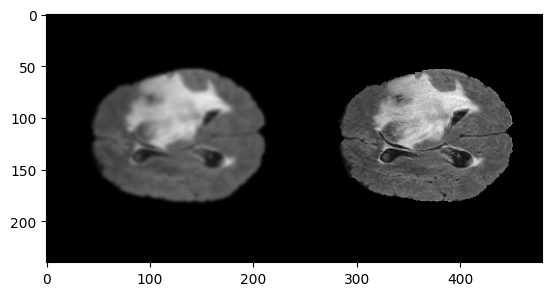

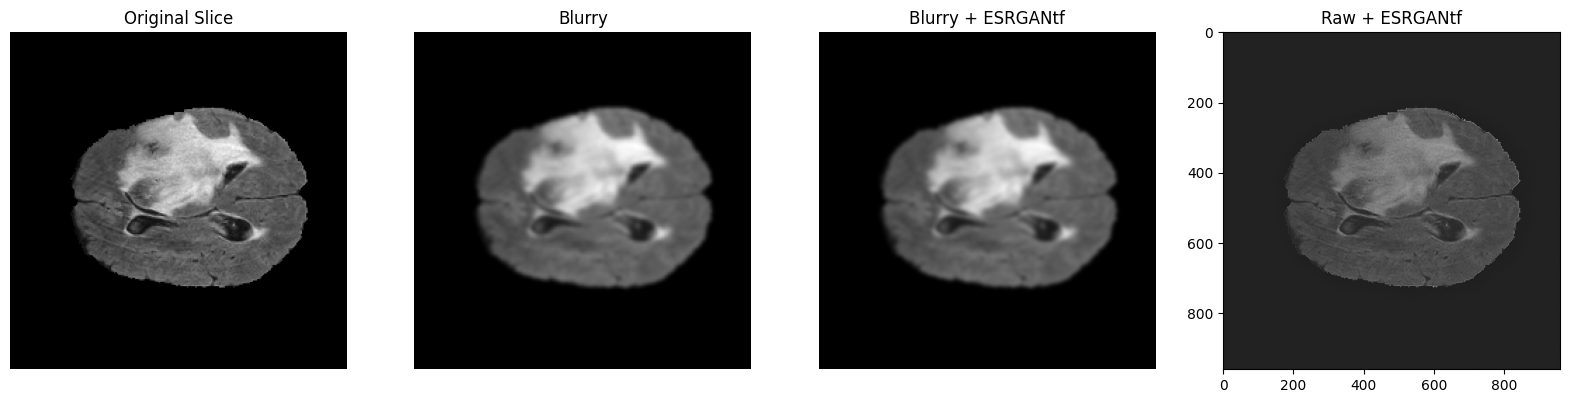

In [ ]:
import tensorflow_hub as hub

from scipy.ndimage import gaussian_filter


# Create synthetic blurry version
raw_slice = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
blurry_slice = gaussian_filter(raw_slice[:,:,80], sigma=1.5)

# Visualize
plt.imshow(np.hstack([blurry_slice, raw_slice[:,:,80]]), cmap='gray')

# Convert to 3-channel RGB and float32
blurry_rgb = tf.repeat(blurry_slice[..., np.newaxis], 3, axis=-1)  # (240, 240, 3)
blurry_rgb = tf.cast(blurry_rgb, tf.float32)
blurry_rgb = blurry_rgb[tf.newaxis, ...]  # (1, 240, 240, 3)

raw = tf.repeat(raw_slice[:, :, 80][..., np.newaxis], 3, axis=-1)  # (240, 240, 3)
raw = tf.cast(raw, tf.float32)
raw = raw[tf.newaxis, ...]

# Load and run ESRGAN
model_tf = hub.load('https://tfhub.dev/captain-pool/esrgan-tf2/1')
sharpened_rgb = model_tf(blurry_rgb, False)  # Second arg = False for inference
raw_sharpened_rgb = model_tf(raw,False)

# Convert back to grayscale
sharpened = sharpened_rgb[0, :, :, 0].numpy()
raw_sharpened = raw_sharpened_rgb[0, :, :, 0].numpy()

# Visualize
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.title("Original Slice")
plt.imshow(raw_slice[:, :, 80], cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title("Blurry")
plt.imshow(blurry_slice, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title("Blurry + ESRGANtf")
plt.imshow(sharpened, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title("Raw + ESRGANtf")
plt.imshow(raw_sharpened, cmap='gray')
plt.show()

#ESRGAN - RRDB NET
pretrained-ESRGAN + RRDB Net
source code: https://www.kaggle.com/code/mbburabak/esrgan-evaluation-on-medical-images/notebook#Brain-Tumor---MRI

In [ ]:
#install pre-trained model
!pip install gdown
import gdown
# ESRGAN x4 weights
gdown.download('https://drive.google.com/file/d/1TPrz5QKd8DHHt1k8SRtm6tMiPjz_Qene/view?usp=drive_link',
               'RRDB_ESRGAN_x4.pth',
               quiet=True,
               fuzzy=True
              )

# ESRGAN architecture script
!wget https://raw.githubusercontent.com/xinntao/ESRGAN/master/RRDBNet_arch.py # ESRGAN architecture


--2025-04-27 18:48:14--  https://raw.githubusercontent.com/xinntao/ESRGAN/master/RRDBNet_arch.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2843 (2.8K) [text/plain]
Saving to: ‘RRDBNet_arch.py’

RRDBNet_arch.py     100%[===================>]   2.78K  --.-KB/s    in 0s      

2025-04-27 18:48:15 (71.3 MB/s) - ‘RRDBNet_arch.py’ saved [2843/2843]



In [ ]:
# ESRGAN setup
scale_factor = 4
net_ESRGAN_path = 'RRDB_ESRGAN_x4.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


import RRDBNet_arch as arch

In [ ]:
# Load ESRGAN model
def preprocess_with_esrgan(image_array):
    """Preprocess a single slice with ESRGAN"""
    # Convert numpy array to PIL Image
    image = Image.fromarray(image_array)
    image = image.convert('RGB')

    # Convert to tensor
    to_tensor = transforms.ToTensor()
    img_tensor = to_tensor(image).unsqueeze(0).to(device)

    # Super-resolve with ESRGAN
    with torch.no_grad():
        output = model_esrgan(img_tensor)

    # Convert back to numpy array
    output = output.squeeze(0).permute(1, 2, 0).cpu().numpy()
    output = (output * 255).astype(np.uint8)

    # Convert to grayscale (since we're working with medical images)
    output = cv2.cvtColor(output, cv2.COLOR_RGB2GRAY)

    return output

scale_factor = 4
net_ESRGAN_path = '/content/RRDB_ESRGAN_x4.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net_ESRGAN = torch.load(net_ESRGAN_path)

# Initialize pre-trained model
model_esrgan = arch.RRDBNet(3, 3, 64, 23, gc=32)
model_esrgan.load_state_dict(torch.load(net_ESRGAN_path), strict=True)
model_esrgan.eval()
model_esrgan = model_esrgan.to(device)

In [ ]:
#example training on single slice
#load ESRGAN model
model_esrgan = arch.RRDBNet(3, 3, 64, 23, gc=32)

# Create blurry version
blurry_slice = gaussian_filter(raw_slice[:, :, 80], sigma=1.5)

# Normalize and convert to 3-channel RGB for ESRGAN
def preprocess_for_esrgan(img):
    img = (img - img.min()) / (img.max() - img.min())  # normalize to [0, 1]
    img = (img * 255).astype(np.uint8)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img_rgb = img_rgb.astype(np.float32) / 255.
    img_tensor = torch.from_numpy(img_rgb).permute(2, 0, 1).unsqueeze(0)  # (1, 3, H, W)
    # Move the tensor to the correct device
    return img_tensor.to(device)

blurry_tensor = preprocess_for_esrgan(blurry_slice)
raw_tensor = preprocess_for_esrgan(raw_slice[:, :, 80])


# Super-resolve with ESRGAN
with torch.no_grad():
    sr_blurry = model_esrgan(blurry_tensor).cpu().squeeze(0).permute(1, 2, 0).numpy()
    sr_raw = model_esrgan(raw_tensor).cpu().squeeze(0).permute(1, 2, 0).numpy()

# Convert to grayscale for visualization
sr_blurry_gray = cv2.cvtColor((sr_blurry * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
sr_raw_gray = cv2.cvtColor((sr_raw * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

#reprocessed with tf2 (attempts)
# sr_raw is (H, W, 3), float32 in [0,1]
sr_raw_tf_input = tf.convert_to_tensor(sr_raw, dtype=tf.float32)
sr_raw_tf_input = sr_raw_tf_input[tf.newaxis, ...]  # shape (1, H, W, 3)
sr_after_tf_esrgan = model_tf(sr_raw_tf_input,False)
# Convert to numpy for visualization
sr_after_tf_np = sr_after_tf_esrgan[0].numpy()
# convert to grayscale
sharpened_tf= cv2.cvtColor((sr_after_tf_np * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.title("Original Slice")
plt.imshow(raw_slice[:, :, 80], cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title("Blurry + ESRGAN")
plt.imshow(sr_blurry_gray, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title("Raw + ESRGAN")
plt.imshow(sr_raw_gray, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title("Reprocessed ESRGAN")
plt.imshow(sharpened_tf, cmap='gray')
plt.show()

plt.tight_layout()
plt.show()

#Main UNET Functoin

In [ ]:
import tensorflow
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import Sequence

IMG_SIZE = 128

In [ ]:
#Loss function

# dice loss as defined above for 4 classes
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = tf.keras.backend.flatten(y_true[:,:,:,i])
        y_pred_f = tf.keras.backend.flatten(y_pred[:,:,:,i])
        intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss



# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = tf.keras.backend.sum(tf.keras.backend.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (tf.keras.backend.sum(tf.keras.backend.square(y_true[:,:,:,1])) + tf.keras.backend.sum(tf.keras.backend.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = tf.keras.backend.sum(tf.keras.backend.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (tf.keras.backend.sum(tf.keras.backend.square(y_true[:,:,:,2])) + tf.keras.backend.sum(tf.keras.backend.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = tf.keras.backend.sum(tf.keras.backend.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (tf.keras.backend.sum(tf.keras.backend.square(y_true[:,:,:,3])) + tf.keras.backend.sum(tf.keras.backend.square(y_pred[:,:,:,3])) + epsilon)


# Computing Precision
def precision(y_true, y_pred):
        true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
        predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
        return precision


# Computing Sensitivity
def sensitivity(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + tf.keras.backend.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + tf.keras.backend.epsilon())

In [ ]:
# source https://naomi-fridman.medium.com/multi-class-image-segmentation-a5cc671e647a
#UNET
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)

    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)


    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)

    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)

    return Model(inputs = inputs, outputs = conv10)
IMG_SIZE=128

input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet(input_layer, 'he_normal', 0.2)
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )

In [ ]:
#generate traininig & testing sets
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]
# file BraTS20_Training_355 has ill formatted name for for seg.nii file
train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')

def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories);


train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2)
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15)

In [ ]:
# DataGenerator from Rastislav's notebook, https://www.kaggle.com/code/rastislav/3d-mri-brain-tumor-segmentation-u-net

class DataGenerator(Sequence):
    def __init__(self, list_IDs, dim=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=2,
                 shuffle=True, data_path=TRAIN_DATASET_PATH, use_esrgan=False):
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.data_path = data_path
        self.use_esrgan = use_esrgan
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        Batch_ids = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(Batch_ids)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))

        for c, i in enumerate(Batch_ids):
            sample_path = os.path.join(self.data_path, i, i)
            t1ce = nib.load(sample_path + '_t1ce.nii').get_fdata()
            flair = nib.load(sample_path + '_flair.nii').get_fdata()
            seg = nib.load(sample_path + '_seg.nii').get_fdata()

            for j in range(VOLUME_SLICES):
                flair_slice = cv2.resize(flair[:, :, j + VOLUME_START_AT], self.dim)
                t1ce_slice = cv2.resize(t1ce[:, :, j + VOLUME_START_AT], self.dim)

                if self.use_esrgan:
                    flair_slice = preprocess_with_esrgan(flair_slice)
                    t1ce_slice = preprocess_with_esrgan(t1ce_slice)
                    flair_slice = cv2.resize(flair_slice, self.dim)
                    t1ce_slice = cv2.resize(t1ce_slice, self.dim)

                X[j + VOLUME_SLICES*c, :, :, 0] = flair_slice
                X[j + VOLUME_SLICES*c, :, :, 1] = t1ce_slice
                y[j + VOLUME_SLICES*c] = seg[:, :, j + VOLUME_START_AT]

        y[y == 4] = 3
        mask = tensorflow.one_hot(y, 4)
        Y = tensorflow.image.resize(mask, self.dim)
        return X/np.max(X), Y


training_generator = DataGenerator(train_ids[:60]) #use only the 60/249 to shorten the train time
valid_generator = DataGenerator(val_ids[:20]) #use only 20/76 to shorten the train time
test_generator = DataGenerator(test_ids)


# show number of data for each dir
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()

showDataLayout()

#Add callback for training process
csv_logger = CSVLogger('training_3D.log', separator=',', append=False)


callbacks = [
#     keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
#                               patience=2, verbose=1, mode='auto'),
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),
#  keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5',
#                             verbose=1, save_best_only=True, save_weights_only = True)
        csv_logger
    ]

New model with ESRGAN-RDB preprocessed slices

In [ ]:
#train model
K.clear_session()

model = build_unet(input_layer, 'he_normal', 0.2)
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )

history =  model.fit(training_generator,
                     epochs=10, #was 35
                     steps_per_epoch=len(train_ids[:60]),
                     callbacks= callbacks,
                     validation_data = valid_generator
                     )
#model.save("model_x1_1.h5")
model.save("model_per_class_NOESRGAN_6010.h5")
model.save("model_per_class_NOESRGAN_6010.keras")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
40/60 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step - accuracy: 0.9827 - dice_coef: 0.2226 - dice_coef_edema: 0.0343 - dice_coef_enhancing: 0.0146 - dice_coef_necrotic: 0.0109 - loss: 1.1006 - mean_io_u: 0.4647 - precision: 0.9804 - sensitivity: 0.7917 - specificity: 0.9950

KeyboardInterrupt: 

In [ ]:
from google.colab import files
files.download('')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
hist = history

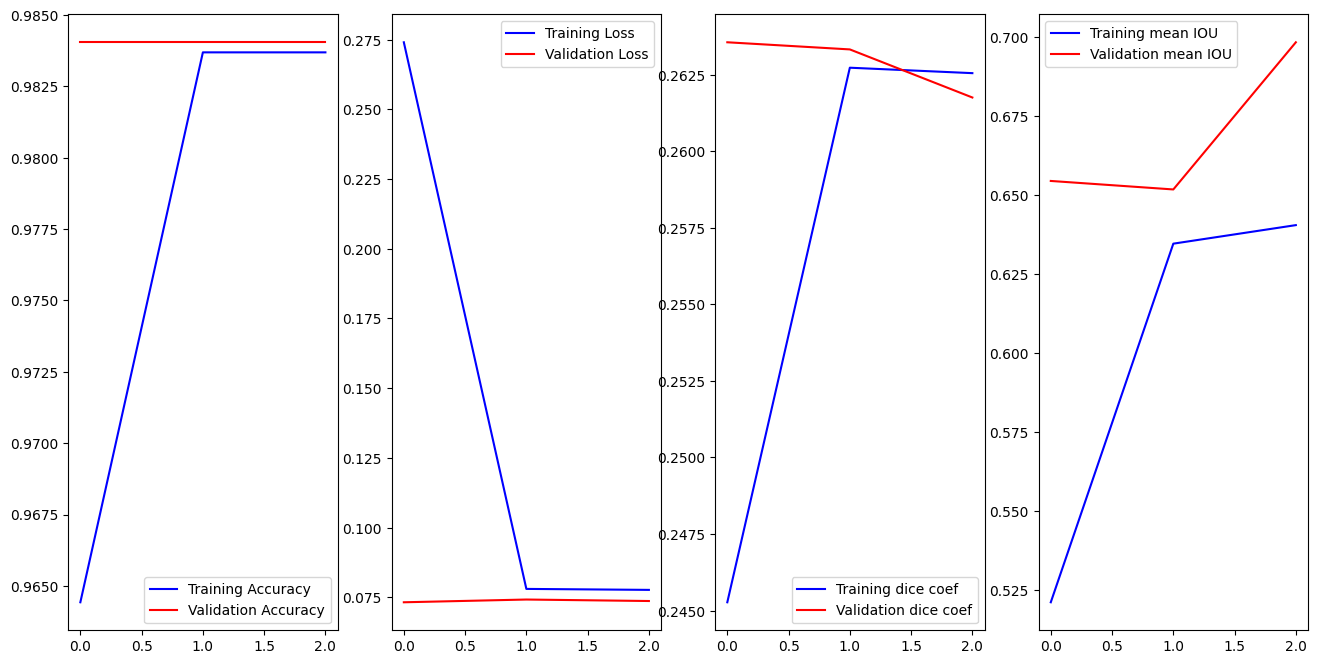

In [ ]:
#ESRGAN preprocessed trained model: model_per_class_ESRGAN.h5
model = keras.models.load_model('/content/model_per_class_ESRGAN.h5',
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)


hist=history.history

############### ########## ####### #######

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist['mean_io_u'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist['val_mean_io_u'],'r',label='Validation mean IOU')
ax[3].legend()

plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 545ms/step


<Figure size 1800x5000 with 0 Axes>

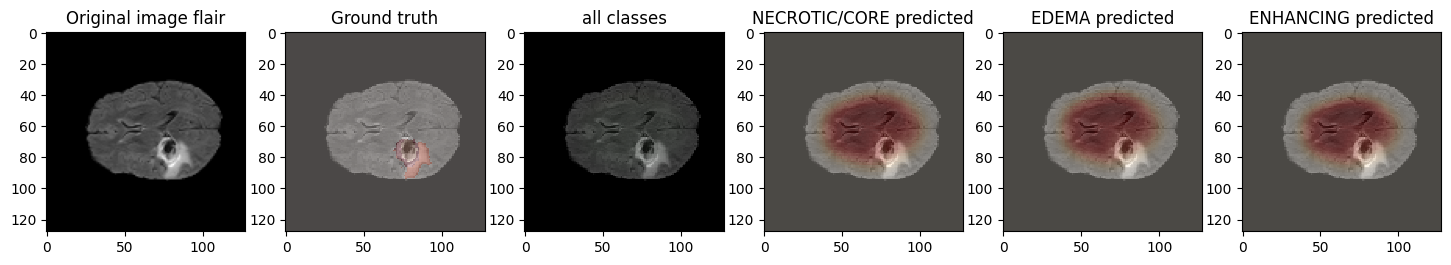

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


<Figure size 1800x5000 with 0 Axes>

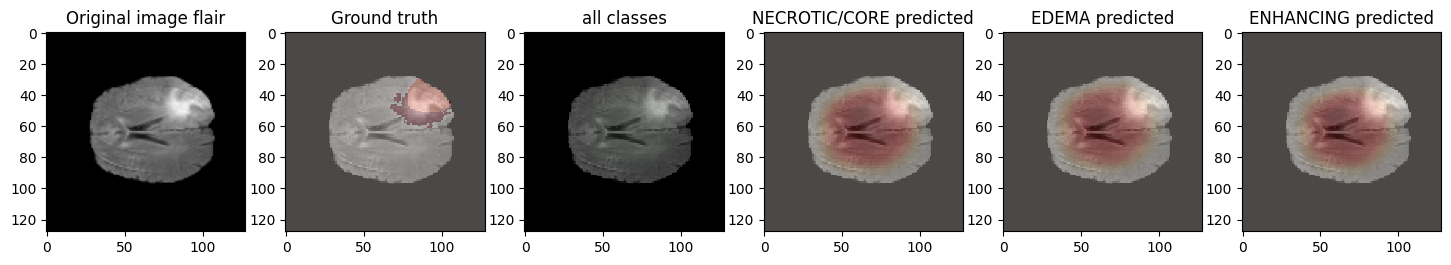

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


<Figure size 1800x5000 with 0 Axes>

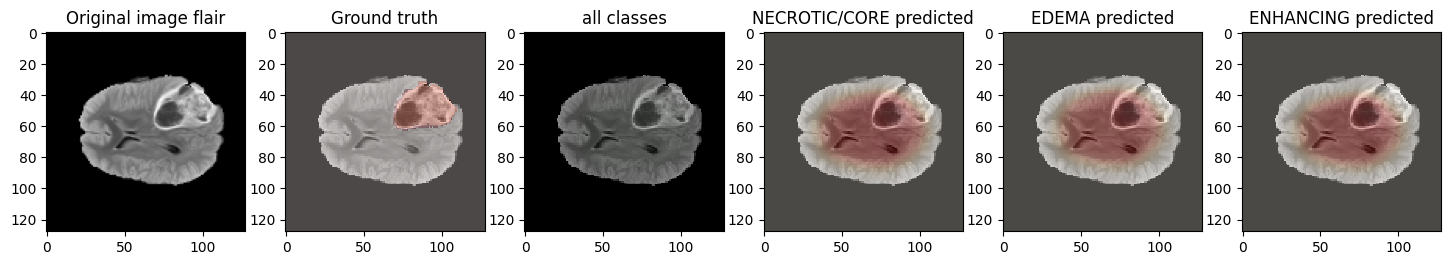

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


<Figure size 1800x5000 with 0 Axes>

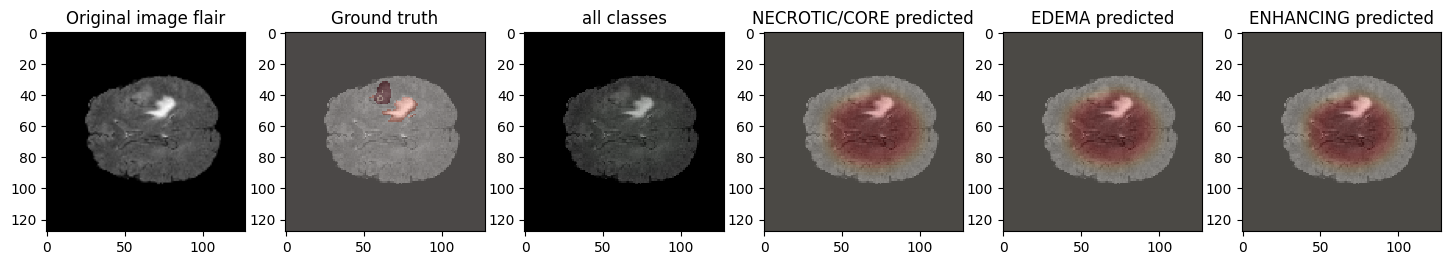

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


<Figure size 1800x5000 with 0 Axes>

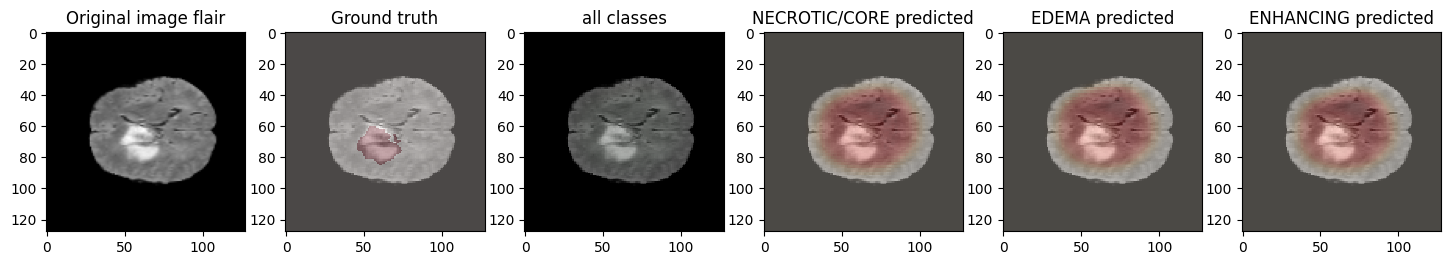

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


<Figure size 1800x5000 with 0 Axes>

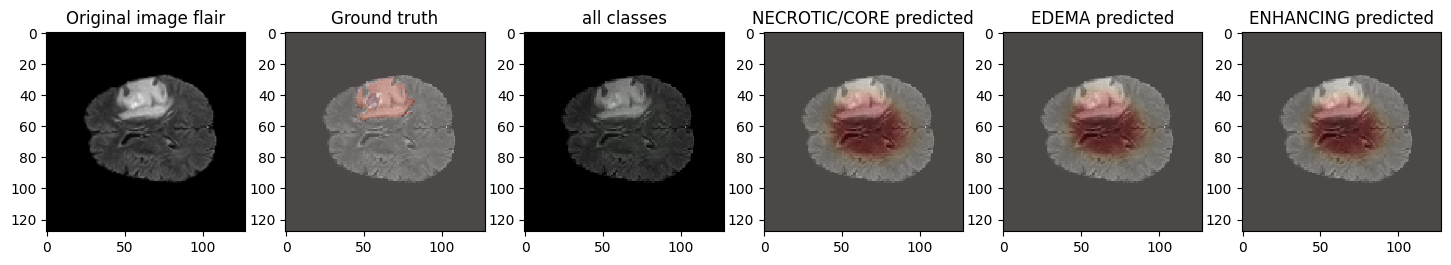

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


<Figure size 1800x5000 with 0 Axes>

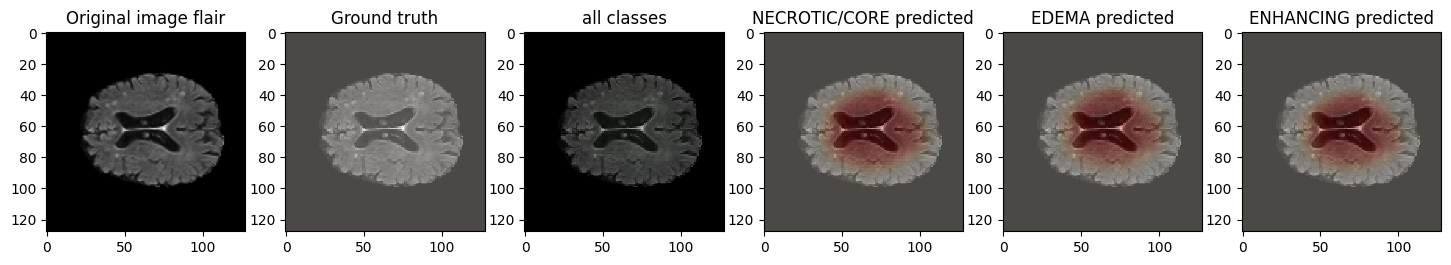

In [ ]:
#ESRGAN preprocessed trained model: model_per_class_ESRGAN.h5
# mri type must one of 1) flair 2) t1 3) t1ce 4) t2 ------- or even 5) seg
# returns volume of specified study at `path`
def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
    for j in range(VOLUME_SLICES):
        X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

        y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
    return np.array(image)


# load nifti file at `path`
# and load each slice with mask from volume
# choose the mri type & resize to `IMG_SIZE`
def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/*seg*')[0] )
        # for each slice in 3D volume, find also it's mask
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')

#brains_list_test, masks_list_test = loadDataFromDir(VALIDATION_DATASET_PATH, test_directories, "flair", 5)

def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
  #  y = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE))

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata()

 #   vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_seg.nii');
 #   seg=nib.load(vol_path).get_fdata()


    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
 #       y[j,:,:] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

  #  model.evaluate(x=X,y=y[:,:,:,0], callbacks= callbacks)
    return model.predict(X/np.max(X), verbose=1)


def showPredictsById(case, start_slice = 60):
    path = f"brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50))

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')

    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()


showPredictsById(case=test_ids[0][-3:])
showPredictsById(case=test_ids[1][-3:])
showPredictsById(case=test_ids[2][-3:])
showPredictsById(case=test_ids[3][-3:])
showPredictsById(case=test_ids[4][-3:])
showPredictsById(case=test_ids[5][-3:])
showPredictsById(case=test_ids[6][-3:])



Pretrained UNET model (original method)

In [ ]:
from tensorflow.keras.layers import *
#load pre-trained model
#upload the model & training log from local repo
############ load trained model ################
model = keras.models.load_model('/content/model_per_class.h5',
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

history = pd.read_csv('/content/training_per_class.log', sep=',', engine='python')

hist=history

############### ########## ####### #######

# hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist['mean_io_u'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist['val_mean_io_u'],'r',label='Validation mean IOU')
ax[3].legend()

plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step


<Figure size 1800x5000 with 0 Axes>

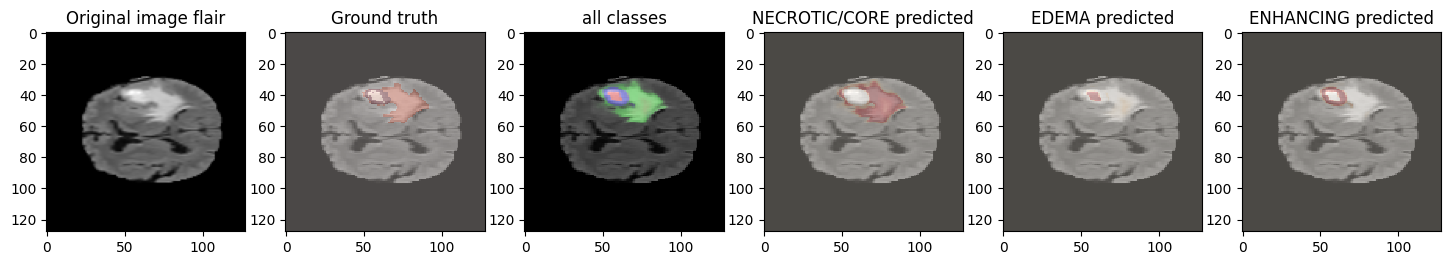

4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step


<Figure size 1800x5000 with 0 Axes>

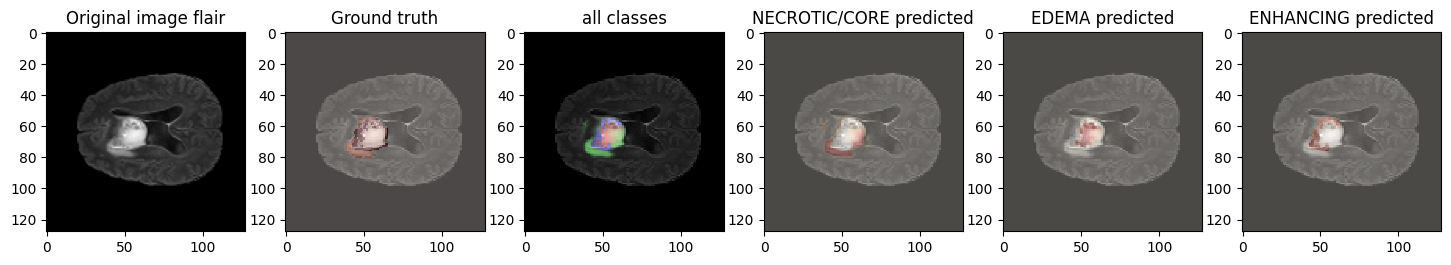

4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step


<Figure size 1800x5000 with 0 Axes>

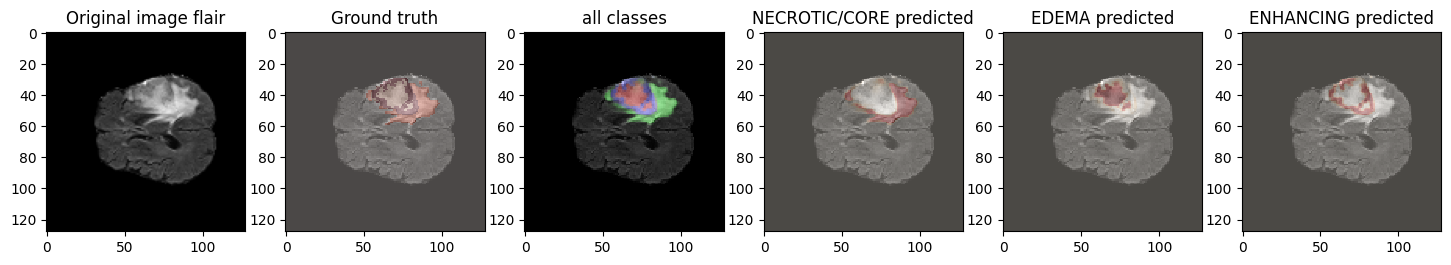

4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step


<Figure size 1800x5000 with 0 Axes>

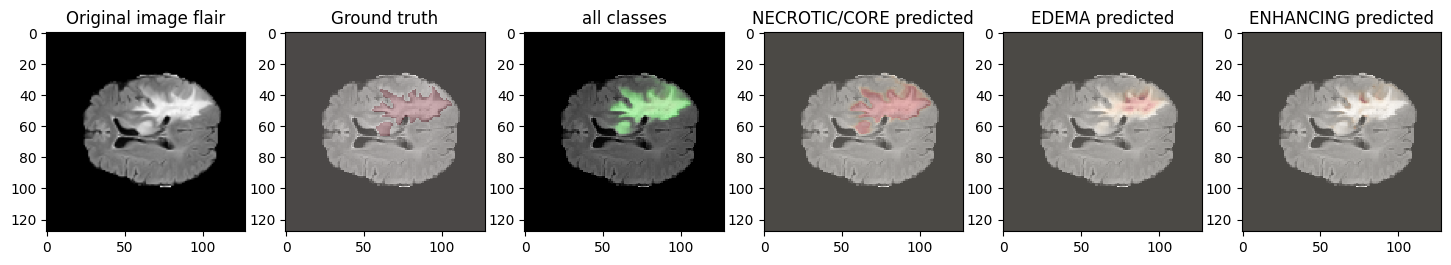

4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step


<Figure size 1800x5000 with 0 Axes>

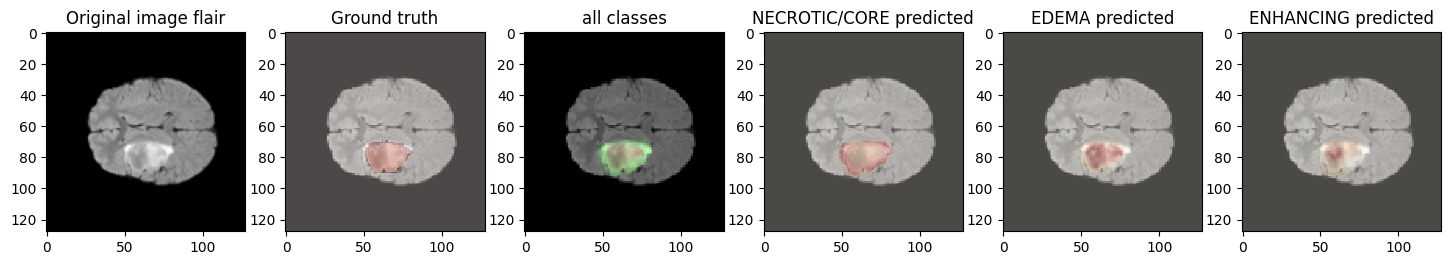

4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step


<Figure size 1800x5000 with 0 Axes>

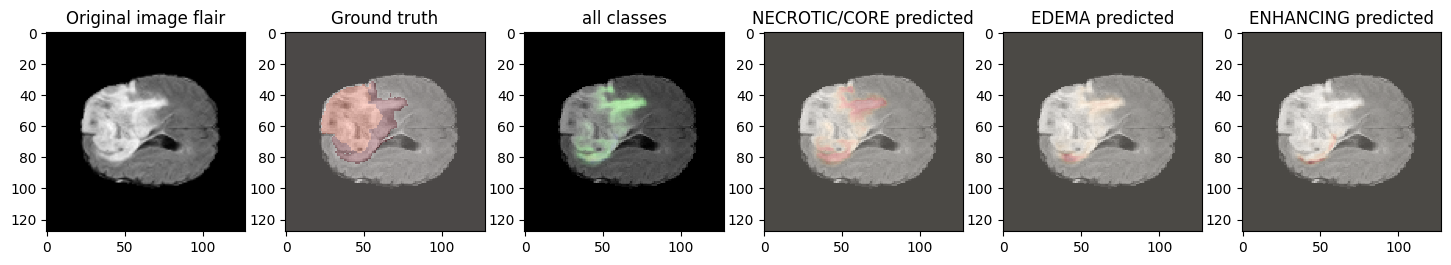

4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step


<Figure size 1800x5000 with 0 Axes>

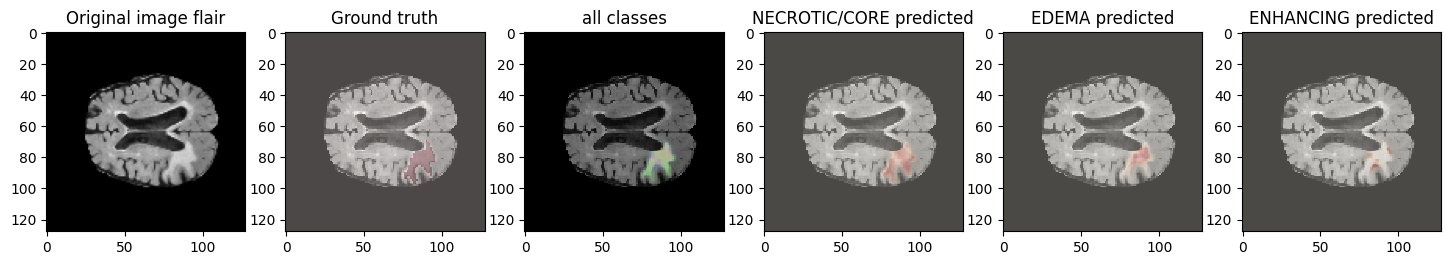

In [ ]:
#original
# mri type must one of 1) flair 2) t1 3) t1ce 4) t2 ------- or even 5) seg
# returns volume of specified study at `path`
def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
    for j in range(VOLUME_SLICES):
        X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

        y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
    return np.array(image)


# load nifti file at `path`
# and load each slice with mask from volume
# choose the mri type & resize to `IMG_SIZE`
def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/*seg*')[0] )
        # for each slice in 3D volume, find also it's mask
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')

#brains_list_test, masks_list_test = loadDataFromDir(VALIDATION_DATASET_PATH, test_directories, "flair", 5)

def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
  #  y = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE))

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata()

 #   vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_seg.nii');
 #   seg=nib.load(vol_path).get_fdata()


    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
 #       y[j,:,:] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

  #  model.evaluate(x=X,y=y[:,:,:,0], callbacks= callbacks)
    return model.predict(X/np.max(X), verbose=1)


def showPredictsById(case, start_slice = 60):
    path = f"brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50))

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')

    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()


showPredictsById(case=test_ids[0][-3:])
showPredictsById(case=test_ids[1][-3:])
showPredictsById(case=test_ids[2][-3:])
showPredictsById(case=test_ids[3][-3:])
showPredictsById(case=test_ids[4][-3:])
showPredictsById(case=test_ids[5][-3:])
showPredictsById(case=test_ids[6][-3:])



In [ ]:
#Evaluation
case = case=test_ids[3][-3:]
path = f"brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
p = predictByPath(path,case)


core = p[:,:,:,1]
edema= p[:,:,:,2]
enhancing = p[:,:,:,3]


i=40 # slice at
eval_class = 2 #     0 : 'NOT tumor',  1 : 'ENHANCING',    2 : 'CORE',    3 : 'WHOLE'



gt[gt != eval_class] = 1 # use only one class for per class evaluation

resized_gt = cv2.resize(gt[:,:,i+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

plt.figure()
f, axarr = plt.subplots(1,2)
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('ground truth')
axarr[1].imshow(p[i,:,:,eval_class], cmap="gray")
axarr[1].title.set_text(f'predicted class: {SEGMENT_CLASSES[eval_class]}')
plt.show()

model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)
print("test loss, test acc:", results)


#Test pre-trained UNET model with pre-processed ESRGAN data

4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step


<Figure size 1800x5000 with 0 Axes>

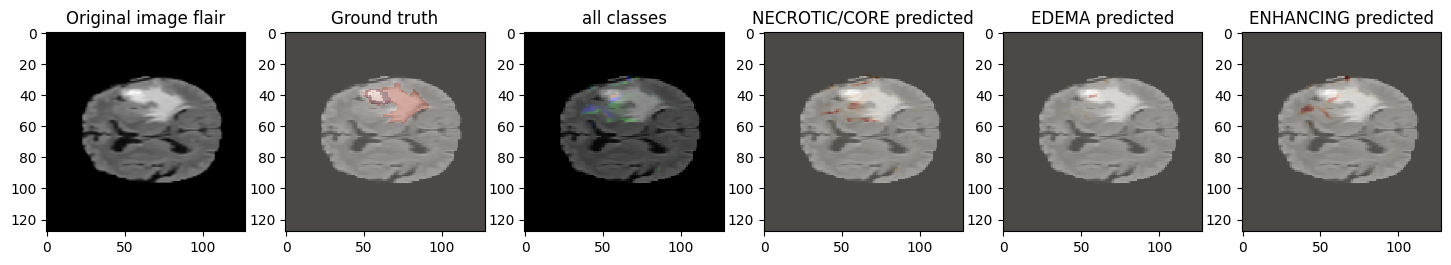

4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step


<Figure size 1800x5000 with 0 Axes>

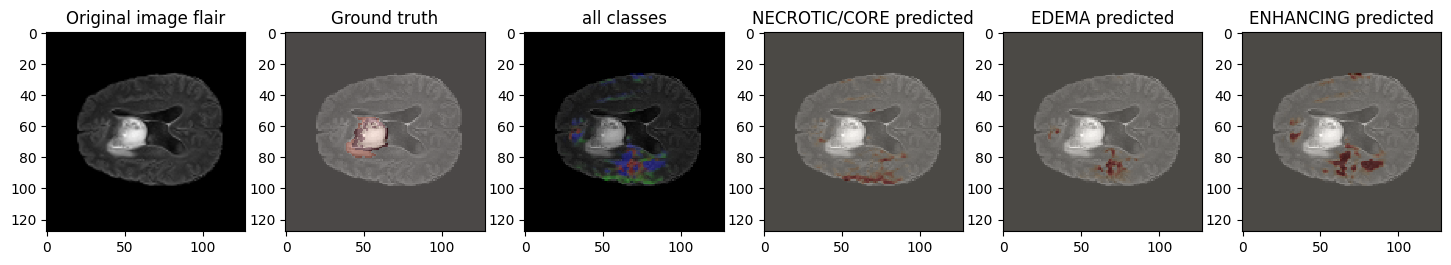

KeyboardInterrupt: 

In [ ]:
#preprocess the slice with ESRGAN & use pre-trained data
# mri type must one of 1) flair 2) t1 3) t1ce 4) t2 ------- or even 5) seg
# returns volume of specified study at `path`
def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    for j in range(VOLUME_SLICES):
        # Get original slice
        slice_img = image[:,:,j+VOLUME_START_AT]

        # Preprocess with ESRGAN
        sr_slice = preprocess_with_esrgan(slice_img)

        # Resize to target size
        X[j,:,:,0] = cv2.resize(sr_slice, (IMG_SIZE, IMG_SIZE))
    # image = nib.load(path).get_fdata()
    # X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
    # for j in range(VOLUME_SLICES):
    #     X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
    #     X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

    #     y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
    return X #np.array(image)


# load nifti file at `path`
# and load each slice with mask from volume
# choose the mri type & resize to `IMG_SIZE`
def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = nib.load(glob.glob(i + '/*seg*')[0]).get_fdata()#imageLoader( glob.glob( i + '/*seg*')[0] )
        # for each slice in 3D volume, find also it's mask
        for j in range(0, currentScanVolume.shape[0]):#(0, currentScanVolume.shape[2]):
            scan_img = currentScanVolume[j,:,:,0]
            mask_img = cv2.resize(currentMaskVolume[:,:,j+VOLUME_START_AT],
                                dsize=(IMG_SIZE,IMG_SIZE),
                                interpolation=cv2.INTER_NEAREST)
            # scan_img = cv2.resize(currentScanVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            # mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')

#brains_list_test, masks_list_test = loadDataFromDir(VALIDATION_DATASET_PATH, test_directories, "flair", 5)


def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
  #  y = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE))

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata()

 #   vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_seg.nii');
 #   seg=nib.load(vol_path).get_fdata()


    for j in range(VOLUME_SLICES):
       # Process flair with ESRGAN
         flair_slice = flair[:,:,j+VOLUME_START_AT]
         sr_flair = preprocess_with_esrgan(flair_slice)
         X[j,:,:,0] = cv2.resize(sr_flair, (IMG_SIZE, IMG_SIZE))

        # Process t1ce with ESRGAN
         ce_slice = ce[:,:,j+VOLUME_START_AT]
         sr_ce = preprocess_with_esrgan(ce_slice)
         X[j,:,:,1] = cv2.resize(sr_ce, (IMG_SIZE, IMG_SIZE))

#         X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
#         X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
#  #       y[j,:,:] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

  #  model.evaluate(x=X,y=y[:,:,:,0], callbacks= callbacks)
    return model.predict(X/np.max(X), verbose=1)


def showPredictsById(case, start_slice = 60):
    path = f"brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50))

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')

    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()


showPredictsById(case=test_ids[0][-3:])
showPredictsById(case=test_ids[1][-3:])
showPredictsById(case=test_ids[2][-3:])
showPredictsById(case=test_ids[3][-3:])
showPredictsById(case=test_ids[4][-3:])
showPredictsById(case=test_ids[5][-3:])
showPredictsById(case=test_ids[6][-3:])



#3DUNET

In [ ]:
import os
os.environ["PYDEVD_DISABLE_FILE_VALIDATION"] = "1"  # Disable file validation


In [ ]:
from tensorflow.keras.layers import Conv3D, MaxPooling3D, UpSampling3D

def build_3d_unet(input_shape=(128, 128, 128, 2), n_classes=4):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv3D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv3D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = Conv3D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv3D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    # Bottleneck
    conv3 = Conv3D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv3D(128, 3, activation='relu', padding='same')(conv3)

    # Decoder
    up1 = UpSampling3D(size=(2, 2, 2))(conv3)
    up1 = Conv3D(64, 2, activation='relu', padding='same')(up1)
    merge1 = concatenate([conv2, up1], axis=4)
    conv4 = Conv3D(64, 3, activation='relu', padding='same')(merge1)
    conv4 = Conv3D(64, 3, activation='relu', padding='same')(conv4)

    up2 = UpSampling3D(size=(2, 2, 2))(conv4)
    up2 = Conv3D(32, 2, activation='relu', padding='same')(up2)
    merge2 = concatenate([conv1, up2], axis=4)
    conv5 = Conv3D(32, 3, activation='relu', padding='same')(merge2)
    conv5 = Conv3D(32, 3, activation='relu', padding='same')(conv5)

    outputs = Conv3D(n_classes, 1, activation='softmax')(conv5)

    return Model(inputs=inputs, outputs=outputs)

In [ ]:
class DataGenerator3D(keras.utils.Sequence):
    def __init__(self, list_IDs, dim=(128,128,128), batch_size=1, n_channels=2, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_ids):
        # Update the shape of y to match the resized segmentation data
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, 4), dtype=np.float32)  # 4 classes

        for i, ID in enumerate(batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, ID)

            # Load volumes
            flair = nib.load(os.path.join(case_path, f'{ID}_flair.nii')).get_fdata()
            ce = nib.load(os.path.join(case_path, f'{ID}_t1ce.nii')).get_fdata()
            seg = nib.load(os.path.join(case_path, f'{ID}_seg.nii')).get_fdata()

            # Resize volumes
            flair = resize(flair, self.dim, preserve_range=True)
            ce = resize(ce, self.dim, preserve_range=True)
            seg = resize(seg, self.dim, preserve_range=True) # Resize the segmentation as well

            X[i,:,:,:,0] = flair
            X[i,:,:,:,1] = ce

            # Process segmentation
            seg[seg==4] = 3  # convert enhancing tumor label
            y[i] = tf.one_hot(seg.astype(np.uint8), 4)

        return X/np.max(X), y

    @property
    def num_batches(self):
        """Returns the number of batches in the dataset."""
        return int(np.floor(len(self.list_IDs) / self.batch_size))

In [ ]:
#Loss function

# dice loss as defined above for 4 classes
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    total_loss = 0  # initialize
    for i in range(class_num):
        y_true_f = tf.keras.backend.flatten(y_true[..., i])  # use ... to handle (batch, depth, height, width, channel)
        y_pred_f = tf.keras.backend.flatten(y_pred[..., i])
        intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
        loss = (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)
        total_loss += loss
    total_loss = total_loss / class_num
    return total_loss




# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = tf.keras.backend.sum(tf.keras.backend.abs(y_true[...,1] * y_pred[...,1]))
    return (2. * intersection) / (tf.keras.backend.sum(tf.keras.backend.square(y_true[...,1])) + tf.keras.backend.sum(tf.keras.backend.square(y_pred[...,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = tf.keras.backend.sum(tf.keras.backend.abs(y_true[...,2] * y_pred[...,2]))
    return (2. * intersection) / (tf.keras.backend.sum(tf.keras.backend.square(y_true[...,2])) + tf.keras.backend.sum(tf.keras.backend.square(y_pred[...,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = tf.keras.backend.sum(tf.keras.backend.abs(y_true[...,3] * y_pred[...,3]))
    return (2. * intersection) / (tf.keras.backend.sum(tf.keras.backend.square(y_true[...,3])) + tf.keras.backend.sum(tf.keras.backend.square(y_pred[...,3])) + epsilon)


# Computing Precision
def precision(y_true, y_pred):
        true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
        predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
        return precision


# Computing Sensitivity
def sensitivity(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + tf.keras.backend.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + tf.keras.backend.epsilon())

In [ ]:
test_gen = DataGenerator3D(test_ids, dim=VOLUME_SHAPE, batch_size=BATCH_SIZE)

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
import tensorflow as tf
import os

SEGMENT_CLASSES = {
    0: 'background',
    1: 'white_matter',
    2: 'gray_matter',
    3: 'cerebrospinal_fluid'
}

# Clear session and define batch size
K.clear_session()
# Reduce these values if you get memory errors
VOLUME_SHAPE = (128, 128, 128)  # Smaller than original 240×240×155
BATCH_SIZE = 2  # Very small batch size due to memory

model = build_3d_unet(input_shape=(*VOLUME_SHAPE, 2))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=[dice_coef])

# Initialize
train_gen = DataGenerator3D(train_ids, dim=VOLUME_SHAPE, batch_size=BATCH_SIZE)
val_gen = DataGenerator3D(val_ids, dim=VOLUME_SHAPE, batch_size=BATCH_SIZE)


csv_logger = CSVLogger('training_3Dunet.log', separator=',', append=False)
# Callbacks
callbacks = [
    ModelCheckpoint('3d_unet.h5', save_best_only=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
    csv_logger
]

# Train
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=callbacks
)


# Save the final model (not just the best checkpoint)
model.save("final_3d_unet.h5")
model.save("final_3d_unet.keras")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


KeyboardInterrupt: 

In [ ]:
from google.colab import files
files.download('final_3d_unet.keras')
files.download('final_3d_unet.h5')
files.download('training_3Dunet.log')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


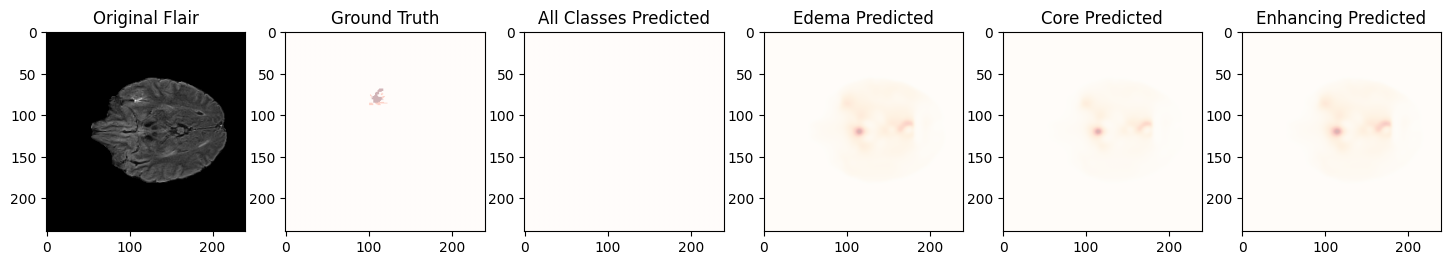

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


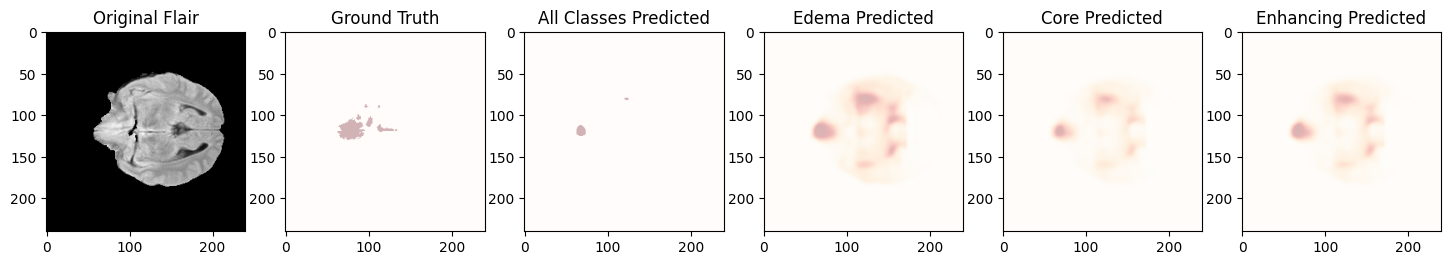

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


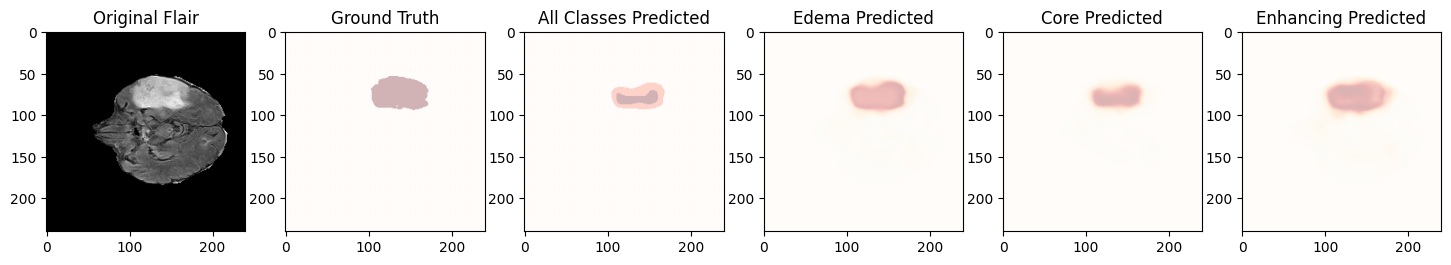

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


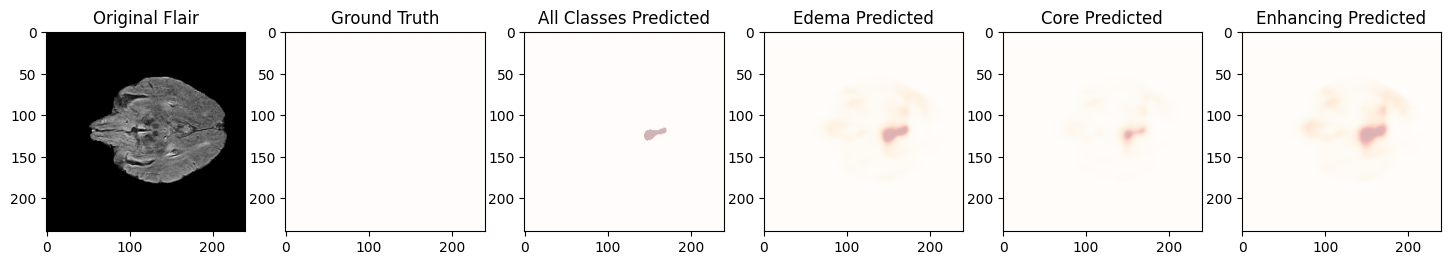

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


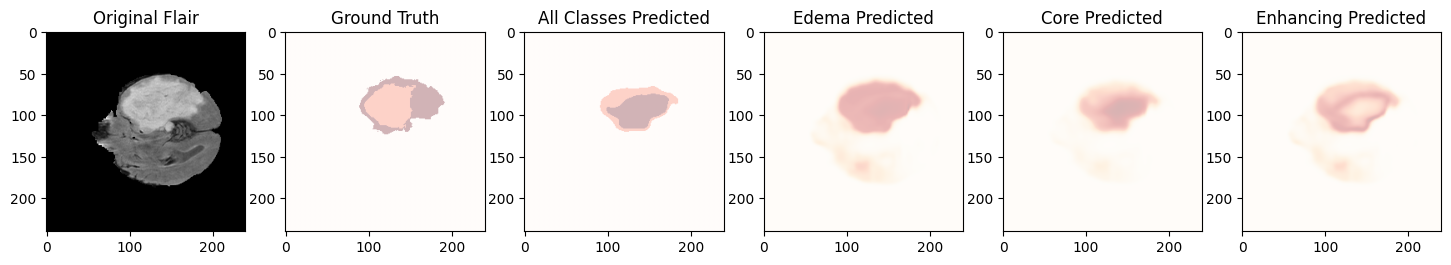

In [ ]:
from skimage.transform import resize
import numpy as np

def predictByPath_3d(case_path, case):
    # Load full volumes
    flair = nib.load(os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    t1ce = nib.load(os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii')).get_fdata()

    # Resize all to 128x128x128
    flair_resized = resize(flair, (128, 128, 128), preserve_range=True)
    t1ce_resized = resize(t1ce, (128, 128, 128), preserve_range=True)

    # Stack channels and normalize
    vol = np.stack([flair_resized, t1ce_resized], axis=-1)  # Shape: (128, 128, 128, 2)
    vol = vol / np.max(vol)
    vol = np.expand_dims(vol, axis=0)  # Add batch dim → (1, 128, 128, 128, 2)

    # Predict
    pred = model.predict(vol, verbose=1)[0]  # Remove batch dim → (128, 128, 128, 4)

    # Resize predictions back to original shape (240, 240, 155)
    pred_resized = np.zeros((240, 240, 155, 4))
    for c in range(4):
        pred_resized[:, :, :, c] = resize(pred[:, :, :, c], (240, 240, 155), preserve_range=True)

    return pred_resized  # Shape: (240, 240, 155, 4)


def showPredictsById_3d(case, slice_num=60):
    path = f"/content/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    orig_flair = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    pred = predictByPath_3d(path, case)  # Shape: (240, 240, 155, 4)

    # Plot
    plt.figure(figsize=(18, 10))
    plt.subplot(1, 6, 1)
    plt.imshow(orig_flair[:, :, slice_num], cmap="gray")
    plt.title('Original Flair')

    plt.subplot(1, 6, 2)
    plt.imshow(gt[:, :, slice_num], cmap="Reds", alpha=0.3)
    plt.title('Ground Truth')

    plt.subplot(1, 6, 3)
    plt.imshow(np.argmax(pred[:, :, slice_num, :], axis=-1), cmap="Reds", alpha=0.3)
    plt.title('All Classes Predicted')

    plt.subplot(1, 6, 4)
    plt.imshow(pred[:, :, slice_num, 1], cmap="OrRd", alpha=0.3)
    plt.title('Edema Predicted')

    plt.subplot(1, 6, 5)
    plt.imshow(pred[:, :, slice_num, 2], cmap="OrRd", alpha=0.3)
    plt.title('Core Predicted')

    plt.subplot(1, 6, 6)
    plt.imshow(pred[:, :, slice_num, 3], cmap="OrRd", alpha=0.3)
    plt.title('Enhancing Predicted')

    plt.show()


# Test on first 5 cases (shows slice 60 of original volume)
for case_id in test_ids[:5]:
    showPredictsById_3d(case=case_id[-3:], slice_num=60)

In [ ]:
!apt-get install graphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


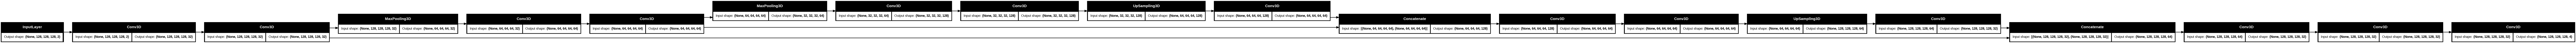

In [ ]:
from tensorflow.keras.utils import plot_model
dmodel = build_3d_unet(input_shape=(*VOLUME_SHAPE, 2))
plot_model(dmodel,
           to_file="3d_model.png",
           show_shapes=True,
           rankdir='LR',
           dpi=96)



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step


<Figure size 640x480 with 0 Axes>

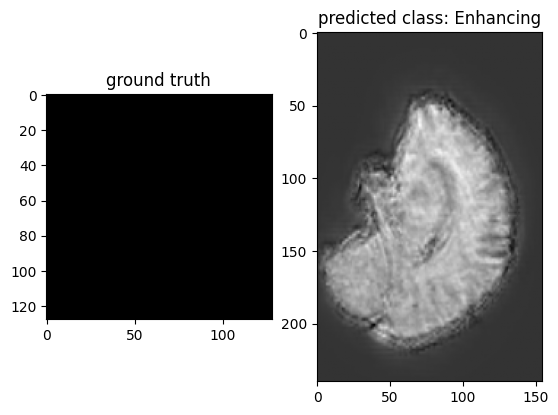

Evaluate on test data
22/22 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.3712 - dice_coef: 0.1062 - dice_coef_edema: 0.0288 - dice_coef_enhancing: 0.0183 - dice_coef_necrotic: 0.0480 - loss: 1.3857 - mean_io_u_2: 0.3750 - precision: 0.0000e+00 - sensitivity: 0.0000e+00 - specificity: 1.0000
test loss, test acc: [1.3856511116027832, 0.37432748079299927, 0.375, 0.10502857714891434, 0.0, 0.0, 1.0, 0.04054781422019005, 0.022893555462360382, 0.014362148009240627]


In [ ]:
#Evaluation
case = case=test_ids[3][-3:]
path = f"brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
p = predictByPath_3d(path,case)


core = p[:,:,:,1]
edema= p[:,:,:,2]
enhancing = p[:,:,:,3]


i=100 # slice at
eval_class = 0 #     0 : 'NOT tumor',  1 : 'ENHANCING',    2 : 'CORE',    3 : 'WHOLE'



gt[gt != eval_class] = 1 # use only one class for per class evaluation

resized_gt = cv2.resize(gt[:,:,i+VOLUME_START_AT], (128,128))

plt.figure()
f, axarr = plt.subplots(1,2)
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('ground truth')
axarr[1].imshow(p[i,:,:,eval_class], cmap="gray")
axarr[1].title.set_text(f'predicted class: {SEGMENT_CLASSES[eval_class]}')
plt.show()

model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_gen, batch_size=100, callbacks= callbacks)
print("test loss, test acc:", results)
